# Tensorflow 2 - BERT Experiment

Author: Rick Qiu 


In [34]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
# Uncomment the pip install commands to install required packages
#!pip install bert-for-tf2
#!pip install sentencepiece
#!pip install tensorflow_hub

In [35]:
# Import modules
import pandas as pd
import numpy as np
import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt

print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)


TensorFlow Version: 2.2.0
Hub version:  0.8.0


## Data preprocessing

In [0]:
# Load the train.csv into Pandas dataframe
df=pd.read_csv('/content/drive/My Drive/data/train.csv')

In [37]:
# Print the column names and the total number of training examples
print('Column names:\n', df.columns.values)
print("\nTotal number of examples:\n", df.shape[0])

Column names:
 ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']

Total number of examples:
 159571


In [38]:
# Identify missing values
df.apply(lambda x: sum(x.isnull()), axis=0)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [0]:
# Shuffle the dataset
df = df.sample(frac=1)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


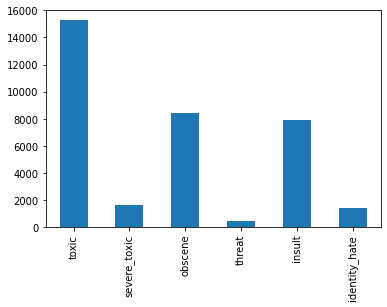

In [40]:
# Plot frequencies of toxic comments per class
classes = df.iloc[:,2:]
classes_freq = classes.sum(axis=0)
print(classes_freq)
classes_freq.plot(kind='bar')



In [0]:
# https://androidkt.com/simple-text-classification-using-bert-in-tensorflow-keras-2-0/
MAX_SEQ_LEN=128 # max sequence length
def get_masks(tokens, max_seq_length):
    """Masks: 1 for real tokens and 0 for paddings"""
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))
 
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""  
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def create_single_input(sentence, tokenizer, MAX_LEN):
  """Create an input from a sentence"""
  stokens = tokenizer.tokenize(sentence)
  stokens = stokens[:MAX_LEN]
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids, masks, segments
 
def convert_sentences_to_features(sentences, tokenizer):
  """Convert sentences to features: input_ids, input_masks and input_segments"""
  input_ids, input_masks, input_segments = [], [], []
 
  for sentence in tqdm(sentences,position=0, leave=True):
    ids,masks,segments=create_single_input(sentence,tokenizer,MAX_SEQ_LEN-2)
    assert len(ids) == MAX_SEQ_LEN
    assert len(masks) == MAX_SEQ_LEN
    assert len(segments) == MAX_SEQ_LEN
 
    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32), 
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

def create_tonkenizer(bert_layer):
    
    vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case=bert_layer.resolved_object.do_lower_case.numpy() 
    tokenizer=bert.bert_tokenization.FullTokenizer(vocab_file,do_lower_case)
    return tokenizer


## NLP model based on BERT

In [42]:
def nlp_model(callable_object):
    # Load saved BERT base model
    bert_layer = hub.KerasLayer(handle=callable_object, trainable=True)  
    # BERT model three inputs: ids, masks and segments
    input_ids = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_ids")           
    input_masks = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_masks")       
    input_segments = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")
    inputs = [input_ids, input_masks, input_segments]
    # BERT model outputs
    pooled_output, sequence_output = bert_layer(inputs)
    # Add custom layers
    x = GlobalAveragePooling1D()(sequence_output)
    x = Dropout(0.2)(x)
    outputs = Dense(6, activation="sigmoid")(x)
    # Construct a new model
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = nlp_model("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1")
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      [(None, 768), (None, 109482241   input_ids[0][0]                  
                                                                 input_masks[0][0]          

## Model training

In [43]:
# Create training examples
tokenizer = create_tonkenizer(model.layers[3])
X_train = convert_sentences_to_features(df["comment_text"].values, tokenizer)
y_train = classes.values

100%|██████████| 159571/159571 [02:46<00:00, 960.03it/s]


In [44]:
# Train the model
epochs=3
batch_size=32

opt = Adam(learning_rate=0.01, decay=1e-5)
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="nlp_model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    shuffle=True, 
                    verbose = 1, 
                    callbacks=[checkpointer, tensorboard])

Epoch 1/3
   2/3990 [..............................] - ETA: 1:21:54 - loss: 3.1242 - accuracy: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.007123). Check your callbacks.


 108/3990 [..............................] - ETA: 29:37 - loss: 0.2913 - accuracy: 0.7025

KeyboardInterrupt: ignored

# New Section